        Player_Name  Batting_Avg  Strike_Rate  StrikeRate_Var  StrikeRate_Std  \
0  Suryakumar Yadav    36.775000   142.046500     2782.471555       52.749138   
1     Aiden Markram    32.409091   142.638637     1541.096705       39.256805   
2        Evin Lewis    30.192308   131.032693     5653.508471       75.189816   
3   Kevin Pietersen    30.153846   136.247308     2127.669111       46.126664   
4       James Vince    29.538462   123.696153     1456.934457       38.169811   
5    Faf du Plessis    29.242424   120.268788     2061.368003       45.402291   
6        Finn Allen    27.909091   144.774546     4558.981263       67.520229   
7    Martin Guptill    27.060976   121.337440     3453.593675       58.767284   
8   Virender Sehwag    26.615385   155.482307     3140.181237       56.037320   
9      David Warner    26.610390   123.917403     4267.235331       65.324079   

      Runs_Var   Runs_Std  
0   896.948077  29.949091  
1   357.015152  18.894845  
2   881.761538  29.69447

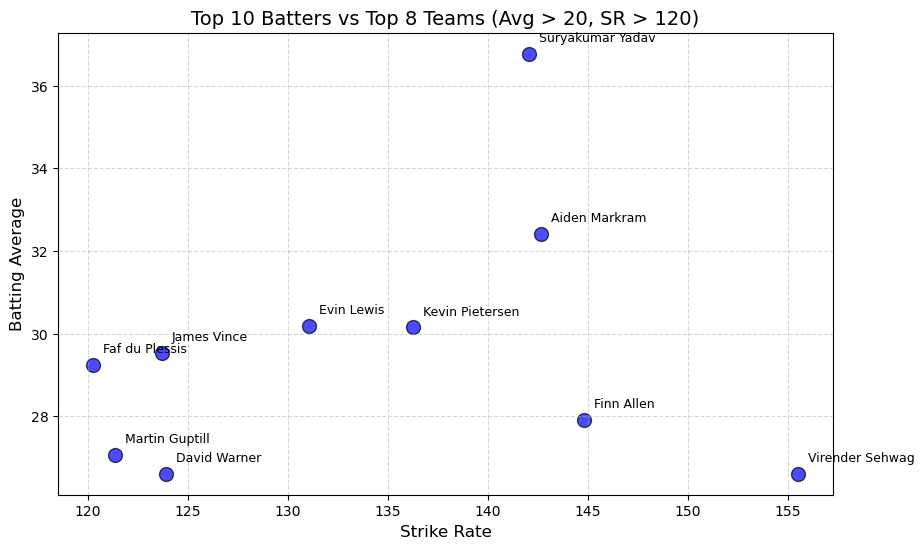

In [ ]:
import pandas as pd
from sqlalchemy import create_engine

server = "DESKTOP-DFD5PNH"
database = "T20I_Data"
driver = "ODBC Driver 17 for SQL Server"

connection_string = f"mssql+pyodbc://@{server}/{database}?driver={driver}"
engine = create_engine(connection_string)

query1 = "SELECT * FROM Match"
df_match = pd.read_sql(query1,engine)
df_match['MOM_Player_ID']=df_match['MOM_Player_ID'].astype("Int64")
df_match['Match_Winner_ID'] = df_match['Match_Winner_ID'].astype("Int64")
df_match['Toss_Winner_ID'] = df_match['Toss_Winner_ID'].astype("Int64")
df_match['Date'] = pd.to_datetime(df_match['Date'], errors='coerce')
query2 = "select * from Batting"
df_batting = pd.read_sql(query2,engine)
query3 = "select * from top8TeamsMatches"
df_view = pd.read_sql(query3,engine)
query3 = "select * from Player"
df_player = pd.read_sql(query3,engine)

merged = df_batting.merge(df_view[['Match_ID']], on='Match_ID', how='inner')

stats = merged.groupby('Player_ID').agg(
    Runs=('Runs', 'sum'),
    Outs=('Is_Out', 'sum'),
    Strike_Rate=('Strike_Rate', 'mean'),
    StrikeRate_Var=('Strike_Rate', 'var'),      
    StrikeRate_Std=('Strike_Rate', 'std'),      
    Runs_Var=('Runs', 'var'),                   
    Runs_Std=('Runs', 'std'),                   
    Innings=('Match_ID', 'count')
).reset_index()


stats['Batting_Avg'] = stats['Runs'] / stats['Outs'].replace(0, pd.NA)

stats = stats.merge(df_player[['Player_ID', 'Player_Name']], on='Player_ID', how='left')


result = stats[
    (stats['Batting_Avg'] > 20) &
    (stats['Strike_Rate'] > 120) &
    (stats['Innings'] >= 10)
]

result = result.sort_values(by='Batting_Avg', ascending=False).reset_index(drop=True)
print(result[['Player_Name','Batting_Avg',
              'Strike_Rate','StrikeRate_Var','StrikeRate_Std',
              'Runs_Var','Runs_Std']].head(10))

import matplotlib.pyplot as plt

plot_df = result[['Player_Name','Batting_Avg','Strike_Rate']].head(10)


plt.figure(figsize=(10,6))
plt.scatter(plot_df['Strike_Rate'], plot_df['Batting_Avg'], s=100, c='blue', alpha=0.7, edgecolors='k')

for i, row in plot_df.iterrows():
    plt.text(row['Strike_Rate']+0.5, row['Batting_Avg']+0.3, row['Player_Name'], fontsize=9)

plt.xlabel("Strike Rate", fontsize=12)
plt.ylabel("Batting Average", fontsize=12)
plt.title("Top 10 Batters vs Top 8 Teams (Avg > 20, SR > 120)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()
